# Parallelization

This weeks notebook is a bit different.  For many of the Python topics, one can utilize Jupyter directly, but this is not optimal for parallelization.  There is a mechanism for running MPI from IPython notebooks via the `ipyparallel` module but I find it clunky to use. If you are interested, you can check it out here: https://ipyparallel.readthedocs.io/en/latest/

For this reason, I have provide several example Python scripts and C codes for you to run, with some markdown comments in the notebook itself.  Also, these will require having MPI and OpenMP working on your machine.  You can install MPI on your laptop. OpenMP may work, but might need to enable it (e.g. via Xcode on Mac). My recommendation is to run these on the Dell server. I have already tested that these codes work there.

The compilation of the C code (OpenMP and MPI) should work without difficulty on the server as everything should already be in the default paths.  The `mpi4py` install might be a bit more tricky.  I used miniconda to install Python on the Dell server and when I tried installing `mpi4py` with pip:
```
pip install mpi4py
```
I got errors where it was unhappy with the Open MPI installation that is on the server. I was too time constrained to sort that out, so I tried using conda instead:
```
conda install -c conda-forge mpi4py openmpi
```
and this worked.

## 1. Using mpi4py

As noted above, `mpi4py` works best with scripts run from the command line and we will proceed with that strategy here.  That said, the scripts can run (serially) in the Jupyter notebook so I copy them below for you to look at and run (if desired).

Let's look at a basic example of an mpi code in the file `mpi_example1.py`.  We can run this in the notebook, but it will only correspond to one process.

In [22]:
# mpi_example1.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    nprocs = comm.Get_size()
    my_rank = comm.Get_rank()
    print("Hello world! My rank: ", my_rank)
    if my_rank == 0:
        print("Number of processes: ", nprocs)

main()

Hello world! My rank:  0
Number of processes:  1


Note that in constrast to C we did not need to initialize or finalize MPI. The `mpi4py` automatically handles this. We did, however, have to set a communicator with:
```
comm = MPI.COMM_WORLD
````
The functions `Get_size()` and `Get_rank()`, as well as those for sending and receiving, etc. are then methods of `comm` instance that is returned.

Running this as a script from the command line allows us to run with mulitple processes.  There are two ways to run this command:
* `mpirun -n 4 python mpi_example1.py`
* `mpiexec -n 4 python mpi_example1.py`

One can also use either `-n` or `-np`. The number 4 means to use four processes. You can run these from the command line or we can use `subprocess.run()` from this notebook:

In [23]:
import subprocess

subprocess.run(["mpirun","-np","4","python","mpi_example1.py"])

Hello world! My rank:  2
Hello world! My rank:  3
Hello world! My rank:  0
Number of processes:  4
Hello world! My rank:  1


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'mpi_example1.py'], returncode=0)

Note that the order in which the processes execute is generally random. We can use the `Barrier()` function to ensure the `Number of procceses` line prints last:

In [24]:
# mpi_example2.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    nprocs = comm.Get_size()
    my_rank = comm.Get_rank()
    print("Hello world! My rank: ", my_rank)

    # ensure that this executes after each rank has completed
    # printing Hello World
    comm.Barrier()
    if my_rank == 0:
        print("Number of processes: ", nprocs)

In [25]:
subprocess.run(["mpirun","-np","4","python","mpi_example2.py"])

Hello world! My rank:  0
Hello world! My rank:  2
Hello world! My rank:  3
Hello world! My rank:  1
Number of processes:  4


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'mpi_example2.py'], returncode=0)

Next consider a case where we want to break up some work across multiple processes. If you look at it, this is really fork-join parallelization so this problem is well suited to OpenMP parallelization on a shared memory machine.  Compare the implementations in `mpi_example3.c` and `omp_example3.c` to see how much simpler the OpenMP implementation is the C codes.

In [42]:
# mpi_exampe3.py
import numpy as np
from mpi4py import MPI

def main():

    # get the MPI communicator
    comm = MPI.COMM_WORLD
    nprocs = comm.Get_size()
    my_rank = comm.Get_rank()
 
    N = 10000000

    # determine the part of the work done by each rank
    npart = [ N // nprocs for i in range(nprocs) ]
    # add any extra if not precisely divisible
    for i in range(N % nprocs):
        npart[i] += 1

    my_beg = 0
    for i in range(my_rank):
        my_beg += npart[i]

    # initialize a
    start_time = MPI.Wtime()
    a = np.empty(npart[my_rank])
    for i in range(npart[my_rank]):
        a[i] = 2*(i + my_beg)
    end_time = MPI.Wtime()
    if my_rank == 0:
        print("Time to initialize a: ",end_time-start_time)

    # initialize b
    start_time = MPI.Wtime()
    b = np.empty(npart[my_rank])
    for i in range(npart[my_rank]):
        b[i] = (i + my_beg)**2
    end_time = MPI.Wtime()
    if my_rank == 0:
        print("Time to initialize b:  ",end_time-start_time)

    # add the two arrays in array c
    c = np.empty(npart[my_rank])
    start_time = MPI.Wtime()
    for i in range(npart[my_rank]):
        c[i] = a[i] + b[i]
    end_time = MPI.Wtime()
    if my_rank == 0:
        print("Time to add arrays: ",end_time-start_time)

    # average the result
    start_time = MPI.Wtime()
    sum = 0
    for i in range(npart[my_rank]):
        sum += c[i]
    local_sum = np.array([sum])
    global_sum = np.zeros(1)
    comm.Reduce(sum, global_sum, op=MPI.SUM, root=0)
    average = global_sum / N
    end_time = MPI.Wtime()
    if my_rank == 0:
        print("Average: ",average[0])
        print("Time to compute average: ",end_time-start_time)


In [43]:
print("Running with 1 process:")
subprocess.run(["mpirun","-np","1","python","mpi_example3.py"])
print("Running with 4 processes:")
subprocess.run(["mpirun","-np","4","python","mpi_example3.py"])

Running with 1 process:
Time to initialize a:  1.620739
Time to initialize b:   4.527000999999999
Time to add arrays:  3.004886
Average:  33333338333349.945
Time to compute average:  1.375375
Running with 4 processes:
Time to initialize a:  0.6238790000000001
Time to initialize b:   1.7651800000000002
Time to add arrays:  1.146757
Average:  33333338333346.223
Time to compute average:  0.5933460000000004


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'mpi_example3.py'], returncode=0)

We can see a notable improvement due to the parallelization in this case because the only communication required is a reduce function at the end and we gave each process large components of the arrays to initialize and sum.

Next, lets try an example with point-to-point communications. Lets use blocking send and receives first.

In [45]:
# mpi_example4.py
from mpi4py import MPI
import numpy as np

def main():
    
    comm = MPI.COMM_WORLD
    my_rank = comm.Get_rank()
    nprocs = comm.Get_size()

    prev = my_rank - 1
    next = my_rank + 1

    if my_rank == 0:
        prev = nprocs - 1
    if my_rank == nprocs - 1:
        next = 0

    rbuf1 = np.empty(1, dtype=int)
    rbuf2 = np.empty(1, dtype=int)
    sbuf = np.array([my_rank], dtype=int)
    
    tag1 = 1
    tag2 = 2

    # blocking sends
    comm.Send([sbuf, MPI.INT], dest=prev, tag=tag2)
    comm.Send([sbuf, MPI.INT], dest=next, tag=tag1)
    # blocking receives
    comm.Recv([rbuf1, MPI.INT], source=prev, tag=tag1)
    comm.Recv([rbuf2, MPI.INT], source=next, tag=tag2)

    print("My rank: {:d} and my neighbors: {:d} {:d}".format(my_rank, rbuf1[0], rbuf2[0]))

In [29]:
subprocess.run(["mpirun","-np","4","python","mpi_example4.py"])

My rank: 2 and my neighbors: 1 3
My rank: 1 and my neighbors: 0 2
My rank: 0 and my neighbors: 3 1
My rank: 3 and my neighbors: 2 0


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'mpi_example4.py'], returncode=0)

Notice that we have the sends execute first, then the receives. What happens if we reverse the order and put the receives first?  Also, note that we used NumPy arrays for the buffers.  `mpi4py` requires the buffers to be contiguous memory blocks. That might be the case for other data types (e.g. lists), but the implementation of NumPy ensures this. NumPy arrays are usually used for send/receive buffers with `mpi4py`.

Note the use tags as well. In some implementations there may be multiple different buffers communicated between the same pair of processes. The tags help to differentiate these communications so that the receiving buffer knows where to place the different buffers that get sent to it.

Now lets look at what we get if we reverse the send and receive order.

In [44]:
# mpi_example5.py
from mpi4py import MPI
import numpy as np

def main():
    
    comm = MPI.COMM_WORLD
    my_rank = comm.Get_rank()
    nprocs = comm.Get_size()

    prev = my_rank - 1
    next = my_rank + 1

    if my_rank == 0:
        prev = nprocs - 1
    if my_rank == nprocs - 1:
        next = 0

    rbuf1 = np.empty(1, dtype=int)
    rbuf2 = np.empty(1, dtype=int)
    sbuf = np.array([my_rank], dtype=int)
    
    tag1 = 1
    tag2 = 2

    # blocking receives
    comm.Recv([rbuf1, MPI.INT], source=prev, tag=tag1)
    comm.Recv([rbuf2, MPI.INT], source=next, tag=tag2)
    # blocking sends
    comm.Send([sbuf, MPI.INT], dest=prev, tag=tag2)
    comm.Send([sbuf, MPI.INT], dest=next, tag=tag1)

    print("My rank: {:d} and my neighbors: {:d} {:d}".format(my_rank, rbuf1[0], rbuf2[0]))


In [60]:
# if you try this, it will just hang because none of the receives
# will complete as no sends can begin until the receives complete

# subprocess.run(["mpirun","-np","4","python","mpi_example5.py"])

Ok. If you know anything about MPI communication, putting blocking receives before the sends is obviously dumb. There are, however, cases where the communication gets more complicated and one can end up in a similar position due to some misunderstood subtlety of execution.

Now lets try the same thing with non-blocking sends and receives.  The non-blocking versions of `Send()` and `Recv()` are `Isend()` and `Irecv()`. Notice that the syntax of the functions is slightly different.  The `Isend()` and `Irecv()` function return MPI request objects while `Send()` and `Recv()` have no return type.  The MPI request stored in the list `reqs` are used by the `Request.Waitall()` function to confirm that all communication has completed before continuing execution.

In [40]:
from mpi4py import MPI
import numpy as np

def main():
    
    comm = MPI.COMM_WORLD
    my_rank = comm.Get_rank()
    nprocs = comm.Get_size()

    prev = my_rank - 1
    next = my_rank + 1

    if my_rank == 0:
        prev = nprocs - 1
    if my_rank == nprocs - 1:
        next = 0

    rbuf1 = np.empty(1, dtype=int)
    rbuf2 = np.empty(1, dtype=int)
    sbuf = np.array([my_rank], dtype=int)
    
    tag1 = 1
    tag2 = 2
    reqs = [None] * 4

    # non-blocking receives
    reqs[0] = comm.Irecv([rbuf1, MPI.INT], source=prev, tag=tag1)
    reqs[1] = comm.Irecv([rbuf2, MPI.INT], source=next, tag=tag2)
    # non-blocking sends
    reqs[2] = comm.Isend([sbuf, MPI.INT], dest=prev, tag=tag2)
    reqs[3] = comm.Isend([sbuf, MPI.INT], dest=next, tag=tag1)

    # can do some work here if you want, e.g. print current
    # state of the receive buffers
    print(rbuf1[0], rbuf2[0])
    
    MPI.Request.Waitall(reqs)
    print("My rank: {:d} and my neighbors: {:d} {:d}".format(my_rank, rbuf1[0], rbuf2[0]))

In [47]:
subprocess.run(["mpirun","-np","4","python","mpi_example6.py"])

4148518944250003456 4153022543877373952
4148518944250003456 4153022543877373952
4148518944250003456 4153022543877373952
My rank: 3 and my neighbors: 2 0
4148518944250003456 4153022543877373952
My rank: 0 and my neighbors: 3 1
My rank: 1 and my neighbors: 0 2
My rank: 2 and my neighbors: 1 3


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'mpi_example6.py'], returncode=0)

Since the send and receive function are non-blocking, it doesn't matter which order we execute in. Control is returned to the calling function and execution continues. Hence, we are free to do more work while we wait for the communication to finish.  In this case, we print the current status of the receive buffers. Most likely, you will find that they are still in the unitialized states, but after the `Waitall()` function terminates, they will be updated with the ranks of their neighbors, which we print.

## 2. MPI with C

At the risk of boring you, I have recreated most of these functions (examples 2, 3, 4, and 6) in C. Compare the MPI implementation `mpi4py` with that of C.  The implementation is logically similar but the syntax is, of course, a little bit different. For example, all of the C codes need to call `MPI_Init()` and `MPI_Finalize()`. The buffers are all pointers in C.

Compare `mpi_example6.c` to `mpi_example6.py`. In C we explicitly declare `MPI_Request` objects that we pass by reference to `MPI_ISend()` and `MPI_IRecv()`.  This `MPI_Request` array is then used by `MPI_Waitall()` to determine when the sends and receives have completed. This function can also return an `MPI_STATUS` object, but we don't need this so we send it `MPI_STATUSES_IGNORE` argument that tells MPI not to bother.

We can execute the files below, but first we need to make them. I have provided Makefile.mpi for this purpose.

In [49]:
subprocess.run(["make","-f","Makefile.mpi"])

mpicc -o mpi_example2 mpi_example2.c -O3


ld: warning: dylib (/usr/local/Cellar/open-mpi/5.0.2/lib/libmpi.dylib) was built for newer macOS version (14.0) than being linked (11.0)


mpicc -o mpi_example3 mpi_example3.c -O3


ld: warning: dylib (/usr/local/Cellar/open-mpi/5.0.2/lib/libmpi.dylib) was built for newer macOS version (14.0) than being linked (11.0)
ld: warning: dylib (/usr/local/Cellar/open-mpi/5.0.2/lib/libmpi.dylib) was built for newer macOS version (14.0) than being linked (11.0)


mpicc -o mpi_example4 mpi_example4.c -O3
mpicc -o mpi_example6 mpi_example6.c -O3


ld: warning: dylib (/usr/local/Cellar/open-mpi/5.0.2/lib/libmpi.dylib) was built for newer macOS version (14.0) than being linked (11.0)


CompletedProcess(args=['make', '-f', 'Makefile.mpi'], returncode=0)

Now try running the examples and compare with Python.

In [52]:
subprocess.run(["mpirun","-np","4","mpi_example2"])

Hello world! My rank: 1
Hello world! My rank: 2
Hello world! My rank: 3
Hello world! My rank: 0
Number of processes: 4


CompletedProcess(args=['mpirun', '-np', '4', 'mpi_example2'], returncode=0)

In [50]:
subprocess.run(["mpirun","-np","4","mpi_example3"])

Time to initialize a: 0.037691
Time to initialize b: 0.031069
Time to add arrays: 0.037002
Average: 33333338333346.222656
Time to compute average: 0.012622


CompletedProcess(args=['mpirun', '-np', '4', 'mpi_example3'], returncode=0)

It should not be a surprise at this point, but we see that the C code runs much faster than the Python code, for the same number of processes.

In [51]:
subprocess.run(["mpirun","-np","4","mpi_example4"])

My rank: 0 and my neighbors: 3 1
My rank: 3 and my neighbors: 2 0
My rank: 1 and my neighbors: 0 2
My rank: 2 and my neighbors: 1 3


CompletedProcess(args=['mpirun', '-np', '4', 'mpi_example4'], returncode=0)

In [53]:
subprocess.run(["mpirun","-np","4","mpi_example6"])

0 0
0 0
My rank: 0 and my neighbors: 3 1
My rank: 1 and my neighbors: 0 2
0 0
My rank: 3 and my neighbors: 2 0
0 0
My rank: 2 and my neighbors: 1 3


CompletedProcess(args=['mpirun', '-np', '4', 'mpi_example6'], returncode=0)

## 3. OpenMP with C

At the risk of boring you even further, I have further recreated a couple of these examples (2 and 3) using OpenMP with C. For these examples, the OpenMP implementation is simpler than the MPI implementation. This is not surprising since we are doing relatively simple problems. If you simply need to spread the operations of four loops accross several processes, this will be easier with OpenMP.  Usually, it is only when you need to code for distributed memory machines or need to do something more sophisticated that MPI becomes the better choice.

Note that you may come up against the stack limits when using OpenMP. The easy way around this is to type
```
ulimit -s ulimited
```
at the Linux command line. This will set the stack size to unlimited. You can confirm that it was reset by typing
```
ulimit -a
```
Again, I have provide a makefile for compiling the codes.

In [54]:
subprocess.run(["make","-f","Makefile.omp"])

gcc -o omp_example2 omp_example2.c -O3 -fopenmp


clang: error: unsupported option '-fopenmp'
clang: error: unsupported option '-fopenmp'
make: *** [omp_example2] Error 1


CompletedProcess(args=['make', '-f', 'Makefile.omp'], returncode=2)

In [ ]:
subprocess.run(["./omp_example2"])

In [ ]:
subprocess.run(["./omp_example3"])

Compare the execution times of `omp_example3` and `mpi_example3` when run with the same number of threads/processes (e.g. by running `mpirun -np 12 mpi_example3`. I found that they were pretty similar so the simplicity of the OpenMP code wins out here.

## **Student Completion**

Now Let's try a slightly more complicated example, using what we learned above.
Let's try solving Poisson's equation using a finite difference relaxation technique. 
$$
\frac{d^2 \phi}{d x^2} = \rho(x).
$$
We will take $\rho$ to be known function of $x$. In this case $\rho = \sin(x)$.
This needs to be supplemented by boundary conditions, which we will specify at $x=0,~1$ as
\begin{eqnarray}
\phi(0) & = & 0, \\
\phi(1) & = & 0.
\end{eqnarray}

The simplest relaxation scheme for solving this is to use Jacobi iteratino, which we discussed earlier in the course.  Representing the second derivative in Poisson's equation as centered difference we can obtain an expression for the updated of $\phi$ as
$$
\phi^{(n+1)}_i =\frac{1}{2} \left(\phi^{(n)}_{i+1} + \phi^{(n)}_{i-1}\right)-\frac{1}{2}\left(\frac{x_{i+1}-x_{i-1}}{2}\right)^2 \rho(x_i)
$$

I provide a serial implementation below and a file jacobi.py which gives the skeleton of an MPI version.  Complete the MPI version of jacobi.py and then test it below.

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def error(phi1, phi2):
    """
    Normalized relative change in phi between two iterations
    """
    TINY = 1e-10 # avoids potential NaN
    dphi = np.abs((phi2-phi1)[1:-1]/(0.5*np.abs(phi1+phi2)+TINY)[1:-1])
    return dphi.sum()

def jacobi(phi, x, rho):
    """
    Jacobi iteration update of poisson's equation
    """
    dx = 0.5*(x[2:]-x[:-2])
    phi[1:-1] = 0.5*(phi[:-2] + phi[2:] - dx*dx*rho[1:-1])
    return phi

def rhs(x):
    """
    Function for the right hand side of Poisson equation
    """
    return np.sin(x)

def relax_solution():
    """
    Solve Poisson's equation using relaxation
    """
    # set parameters for iteration
    eps = 1e-7
    itermax = 1000000
    # initialize grid and rhs
    x0 = 0
    x1 = 1
    nx = 82
    x = np.linspace(x0,x1,nx)
    phi = np.zeros(x.size)
    rho = rhs(x)

    err = 10*eps # ensure while executes
    iterations = 0
    while err > eps:
        iterations += 1
        phinew = phi.copy()
        phinew = jacobi(phinew, x, rho)

        err = error(phi, phinew)
        phi = phinew
        if iterations == itermax:
            break
    print("Total iteration: {0} {1:.3e}".format(iterations, err))

    return x, phi

Total iteration: 17677 9.999e-08


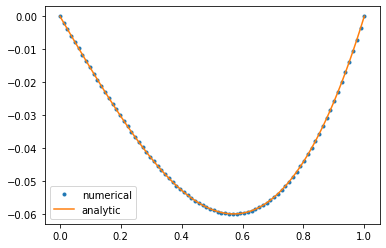

In [56]:
# Compute solution and plot
x, phi = relax_solution()

plt.plot(x, phi, '.',label="numerical")
plt.plot(x,-np.sin(x)+x*np.sin(1), label="analytic")
plt.legend(loc="best")
plt.show()

I have also written a modified version of this in `jacobi.py`, which can be run with mpi from the command line. My implementation works with a single mpi process. It should take the same number of iterations as above and will produce a file called `jacobi.png` that should look like the one above. Let's try it:

In [64]:
import subprocess
subprocess.run(["mpirun","-np","1","python","jacobi.py"])

Total iteration: 17677 9.999e-08
Time with 1 processors: 2.729190e-01


CompletedProcess(args=['mpirun', '-np', '1', 'python', 'jacobi.py'], returncode=0)

Now write an MPI version of the code by modifying the `main()` function in `jacobi.py`. We will do this using domain decomposition.

For example, consider a case where we have a grid of 10 point indexed from $i=0,\dots,9$. The $i=0,9$ points represent the fixed boundaries of the global grid and the calculation updates points $i=1,\dots,8$. Now imagine we split this grid in two parts with process 0 update $i=1,2,3,4$ and process 1 updating $i=5,6,7,8$. On both processes we create a grid of *six* points (indexed by $j=0,\dots,5$).

For process 0, the $j=0$ point is still the fixed boundary, $j=1,\dots,4$ are the global $i=1,2,3,4$ and point $j=5$ is a location to store a copy of the point corresponding to $i=5$ on the global grid, which is on process 1. For process 0, the $j=0$ point is the global $i=4$, which is stored as $j=4$ on process 0, points $j=1,\dots,4$ are the global $i=5,6,7,8$ and point $j=5$ is the fixed boundary corresponding to $i=9$. Of course, we can generalize this to a larger number of processes, particularly if we have more points.  This is easiest if the global grid (minus the fixed endpoints) is divisble by the number MPI processes used so that each local grid is the same size.

But how do we set $j=5$ on process 0 and $j=0$ on proccess 1?  You will need to use MPI to communicate them after each iteration.  You can do this using blocking communcation `Send()` and `Recv()`. Process 0 will send its $j=4$ to process 1 and process 1 will store it in its $j=0$. Process 1 will send $j=1$ and process 0 will store it in its $j=5$ Since the endpoints continue to *not* be updated on the local grid, the `jacobi()` function does not need to be changed from the above implementation.

Now try your implementation out with four processes:

In [69]:
import subprocess
subprocess.run(["mpirun","-np","4","python","jacobi.py"])

Total iteration: 1303 9.899e-08
Time with 4 processors: 3.419800e-02


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'jacobi.py'], returncode=0)

If you did this correctly, it should take the exact same number of iterations and procude an identical plot to what you obtain with a single process.  You will also likely find that it takes **longer** to run! What a bummer -- all that work and it is slower. This is because we are not really doing enough work in our `jacobi` function to overcome the latency and overhead associated with the communication.  We need to do more work per send/receive than we can easily do with such a simple 1D problem. We could, of course, make the array larger e.g. 800002 rather than 82, as we did in our `mpi_example3` above, but it turns out that the size of the array impacts the rate of convergence and signifcantly increase the numer of iterations required so I would not recommend pursuing this approach.